In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

# Load the dataset (make sure the file is in the same directory or update the path)
df = pd.read_csv("/Users/usufahmed/Desktop/CARDIO/ Data.csv", header=1)

# Drop completely empty columns and rows with any missing values
df = df.dropna(axis=1, how='all').dropna(axis=0, how='any')

# Ensure the labels are integer
df['CLASS'] = df['CLASS'].astype(int)
df['NSP'] = df['NSP'].astype(int)

# Separate input features and targets
X = df.drop(columns=['CLASS', 'NSP'])
y_class = df['CLASS'].values.reshape(-1, 1)
y_nsp = df['NSP'].values.reshape(-1, 1)

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# One-hot encode the labels
encoder_class = OneHotEncoder(sparse_output=False)
encoder_nsp = OneHotEncoder(sparse_output=False)

y_class_encoded = encoder_class.fit_transform(y_class)
y_nsp_encoded = encoder_nsp.fit_transform(y_nsp)

# Train-test split (80-20)
X_train, X_test, y_class_train, y_class_test, y_nsp_train, y_nsp_test = train_test_split(
    X_scaled, y_class_encoded, y_nsp_encoded, test_size=0.2, random_state=42, stratify=y_nsp
)

# Optional: print shapes
print("X_train:", X_train.shape)
print("y_class_train:", y_class_train.shape)
print("y_nsp_train:", y_nsp_train.shape)


X_train: (1700, 40)
y_class_train: (1700, 10)
y_nsp_train: (1700, 3)


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

def preprocess_ctg_data(path="/Users/usufahmed/Desktop/CARDIO/ Data.csv"):
    df = pd.read_csv(path, header=1)
    df = df.dropna(axis=1, how='all').dropna(axis=0, how='any')
    df['CLASS'] = df['CLASS'].astype(int)
    df['NSP'] = df['NSP'].astype(int)

    X = df.drop(columns=['CLASS', 'NSP'])
    y_class = df['CLASS'].values.reshape(-1, 1)
    y_nsp = df['NSP'].values.reshape(-1, 1)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    enc_class = OneHotEncoder()
    enc_nsp = OneHotEncoder()
    y_class_encoded = enc_class.fit_transform(y_class).toarray()
    y_nsp_encoded = enc_nsp.fit_transform(y_nsp).toarray()

    X_train, X_test, y_class_train, y_class_test, y_nsp_train, y_nsp_test = train_test_split(
        X_scaled, y_class_encoded, y_nsp_encoded, test_size=0.2, random_state=42, stratify=y_nsp
    )

    return X_train, X_test, y_class_train, y_class_test, y_nsp_train, y_nsp_test


In [4]:
X_train, X_test, y_class_train, y_class_test, y_nsp_train, y_nsp_test = preprocess_ctg_data()


Epoch 1/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - class_output_accuracy: 0.3406 - class_output_loss: 1.9713 - loss: 2.8197 - nsp_output_accuracy: 0.6548 - nsp_output_loss: 0.8480 - val_class_output_accuracy: 0.8765 - val_class_output_loss: 0.7794 - val_loss: 1.0883 - val_nsp_output_accuracy: 0.9324 - val_nsp_output_loss: 0.3140
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - class_output_accuracy: 0.8796 - class_output_loss: 0.5676 - loss: 0.8173 - nsp_output_accuracy: 0.9229 - nsp_output_loss: 0.2494 - val_class_output_accuracy: 0.9971 - val_class_output_loss: 0.0995 - val_loss: 0.2059 - val_nsp_output_accuracy: 0.9853 - val_nsp_output_loss: 0.1191
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step - class_output_accuracy: 0.9906 - class_output_loss: 0.0919 - loss: 0.1598 - nsp_output_accuracy: 0.9873 - nsp_output_loss: 0.0679 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 0.0196 - val_loss: 0.1044 - val_nsp_output_accuracy: 0.9824 - val_nsp_output_loss: 0.09

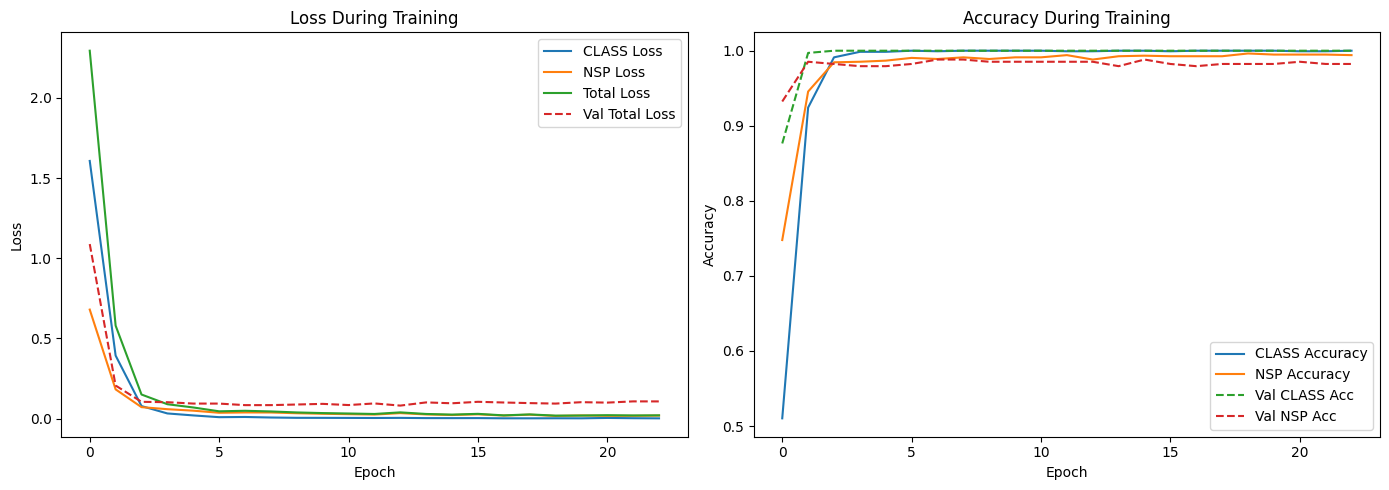

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Input layer
input_layer = Input(shape=(X_train.shape[1],))

# Shared hidden layers
x = Dense(128, activation='relu')(input_layer)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)

# CLASS output branch (10 classes)
class_output = Dense(32, activation='relu')(x)
class_output = Dense(10, activation='softmax', name='class_output')(class_output)

# NSP output branch (3 classes)
nsp_output = Dense(32, activation='relu')(x)
nsp_output = Dense(3, activation='softmax', name='nsp_output')(nsp_output)

# Define model
model = Model(inputs=input_layer, outputs=[class_output, nsp_output])

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss={
        'class_output': 'categorical_crossentropy',
        'nsp_output': 'categorical_crossentropy'
    },
    metrics={
        'class_output': 'accuracy',
        'nsp_output': 'accuracy'
    }
)

# Define early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train,
    {'class_output': y_class_train, 'nsp_output': y_nsp_train},
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)
import matplotlib.pyplot as plt

# Plot loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['class_output_loss'], label='CLASS Loss')
plt.plot(history.history['nsp_output_loss'], label='NSP Loss')
plt.plot(history.history['loss'], label='Total Loss')
plt.plot(history.history['val_loss'], label='Val Total Loss', linestyle='--')
plt.title('Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['class_output_accuracy'], label='CLASS Accuracy')
plt.plot(history.history['nsp_output_accuracy'], label='NSP Accuracy')
plt.plot(history.history['val_class_output_accuracy'], label='Val CLASS Acc', linestyle='--')
plt.plot(history.history['val_nsp_output_accuracy'], label='Val NSP Acc', linestyle='--')
plt.title('Accuracy During Training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [6]:
# Evaluate the model
results = model.evaluate(
    X_test,
    {'class_output': y_class_test, 'nsp_output': y_nsp_test},
    verbose=1
)

print("\n📊 Test Results:")
print(f"Total Loss:        {results[0]:.4f}")
print(f"CLASS Accuracy:    {results[3]:.4f}")
print(f"NSP Accuracy:      {results[4]:.4f}")


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step - class_output_accuracy: 0.9916 - class_output_loss: 0.0556 - loss: 0.1278 - nsp_output_accuracy: 0.9900 - nsp_output_loss: 0.0718

📊 Test Results:
Total Loss:        0.0738
CLASS Accuracy:    0.9953
NSP Accuracy:      0.9930


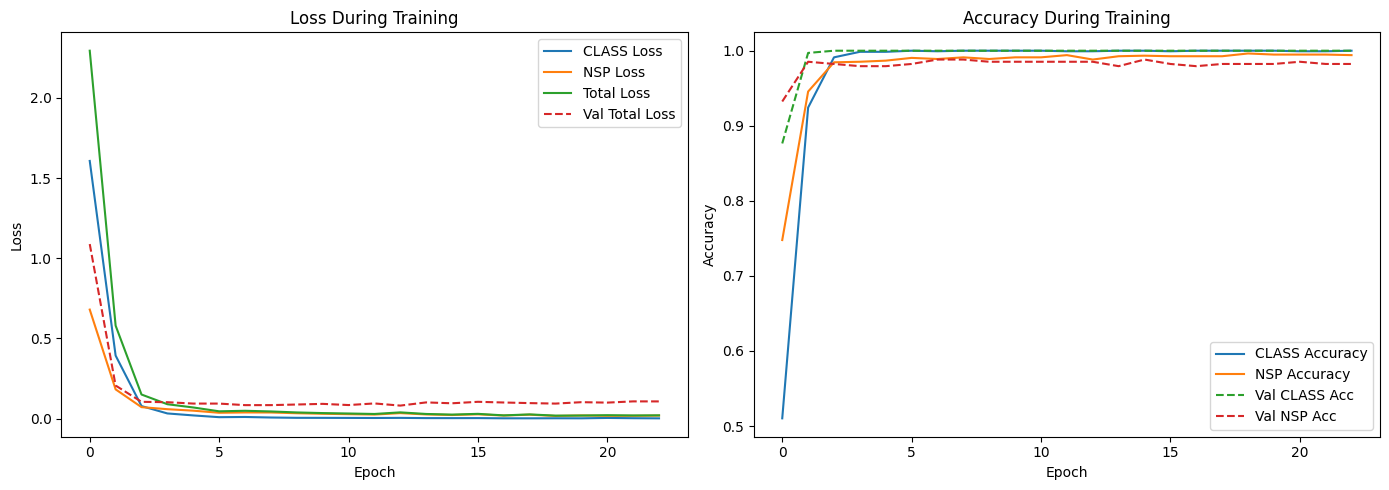

In [7]:
import matplotlib.pyplot as plt

if 'history' in globals():
	# Plot loss
	plt.figure(figsize=(14, 5))
	plt.subplot(1, 2, 1)
	plt.plot(history.history['class_output_loss'], label='CLASS Loss')
	plt.plot(history.history['nsp_output_loss'], label='NSP Loss')
	plt.plot(history.history['loss'], label='Total Loss')
	plt.plot(history.history['val_loss'], label='Val Total Loss', linestyle='--')
	plt.title('Loss During Training')
	plt.xlabel('Epoch')
	plt.ylabel('Loss')
	plt.legend()

	# Plot accuracy
	plt.subplot(1, 2, 2)
	plt.plot(history.history['class_output_accuracy'], label='CLASS Accuracy')
	plt.plot(history.history['nsp_output_accuracy'], label='NSP Accuracy')
	plt.plot(history.history['val_class_output_accuracy'], label='Val CLASS Acc', linestyle='--')
	plt.plot(history.history['val_nsp_output_accuracy'], label='Val NSP Acc', linestyle='--')
	plt.title('Accuracy During Training')
	plt.xlabel('Epoch')
	plt.ylabel('Accuracy')
	plt.legend()

	plt.tight_layout()
	plt.show()
else:
	print("Error: 'history' is not defined. Please run the cell where the model is trained.")


Note: you may need to restart the kernel to use updated packages.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step
📋 CLASS Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        70
           1       1.00      1.00      1.00       111
           2       1.00      1.00      1.00        15
           3       1.00      1.00      1.00        15
           4       1.00      1.00      1.00        15
           5       1.00      0.97      0.98        67
           6       0.98      1.00      0.99        63
           7       0.95      1.00      0.97        19
           8       1.00      1.00      1.00        16
           9       1.00      1.00      1.00        35

    accuracy                           1.00       426
   macro avg       0.99      1.00      1.00       426
weighted avg       1.00      1.00      1.00       426

📋 NSP Classification Report:
              precision    recall 

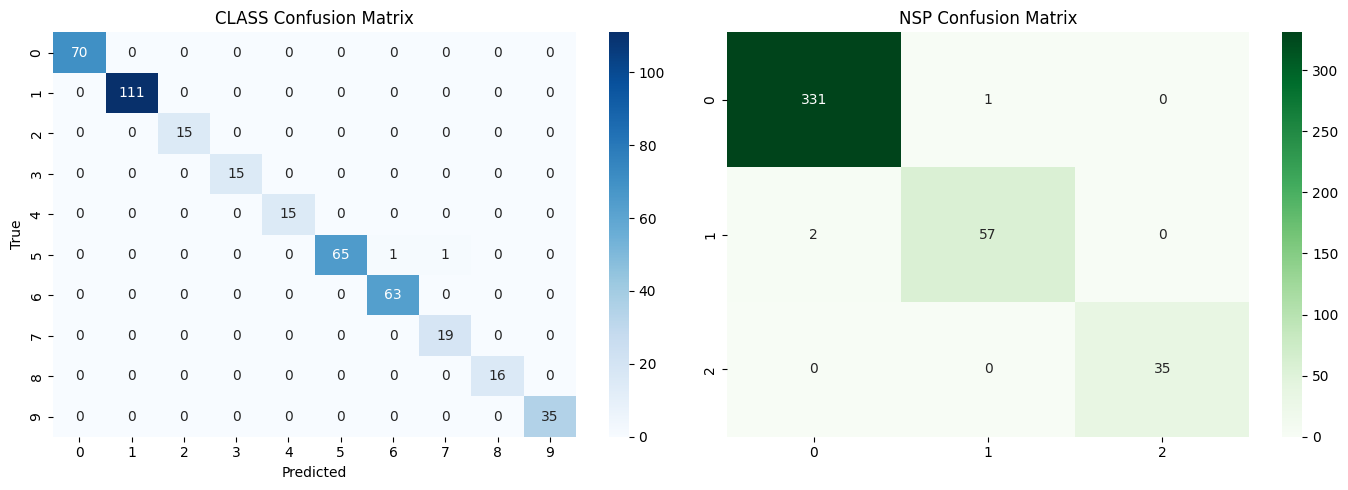

In [8]:
%pip install seaborn
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predict on test data
y_pred_class = model.predict(X_test)[0]  # First output is CLASS
y_pred_nsp = model.predict(X_test)[1]    # Second output is NSP

# Convert from one-hot to class index
y_pred_class_labels = y_pred_class.argmax(axis=1)
y_true_class_labels = y_class_test.argmax(axis=1)

y_pred_nsp_labels = y_pred_nsp.argmax(axis=1)
y_true_nsp_labels = y_nsp_test.argmax(axis=1)

# Classification reports
print("📋 CLASS Classification Report:")
print(classification_report(y_true_class_labels, y_pred_class_labels))

print("📋 NSP Classification Report:")
print(classification_report(y_true_nsp_labels, y_pred_nsp_labels))

# Confusion matrices
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(confusion_matrix(y_true_class_labels, y_pred_class_labels), annot=True, fmt='d', ax=ax[0], cmap='Blues')
ax[0].set_title('CLASS Confusion Matrix')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('True')

sns.heatmap(confusion_matrix(y_true_nsp_labels, y_pred_nsp_labels), annot=True, fmt='d', ax=ax[1], cmap='Greens')
ax[1].set_title('NSP Confusion Matrix')

plt.tight_layout()
plt.show()


In [ ]:
import joblib

# Save model
model.save("ctg_multitask_model.keras")

# Save scaler and encoders
joblib.dump(scaler, "scaler.pkl")
joblib.dump(encoder_class, "encoder_class.pkl")
joblib.dump(encoder_nsp, "encoder_nsp.pkl")

print("✅ Model and preprocessing objects saved.")


✅ Model and preprocessing objects saved.


In [23]:
from sklearn.metrics import accuracy_score

# Get predictions
pred_class_probs, pred_nsp_probs = model.predict(X_test)

# Convert from probabilities (softmax) to label indices
pred_class_labels = pred_class_probs.argmax(axis=1)
true_class_labels = y_class_test.argmax(axis=1)

pred_nsp_labels = pred_nsp_probs.argmax(axis=1)
true_nsp_labels = y_nsp_test.argmax(axis=1)

# Compute accuracies
class_acc = accuracy_score(true_class_labels, pred_class_labels)
nsp_acc = accuracy_score(true_nsp_labels, pred_nsp_labels)

print(f"✅ Test Accuracy for CLASS prediction: {class_acc:.4f}")
print(f"✅ Test Accuracy for NSP prediction:   {nsp_acc:.4f}")


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
✅ Test Accuracy for CLASS prediction: 0.9977
✅ Test Accuracy for NSP prediction:   0.9883


In [26]:
import numpy as np
import joblib
from tensorflow.keras.models import load_model

# === Load model and preprocessing objects ===
model = load_model("ctg_multitask_model.keras")
scaler = joblib.load("scaler.pkl")
encoder_class = joblib.load("encoder_class.pkl")
encoder_nsp = joblib.load("encoder_nsp.pkl")

# === Example input (40 features as a list) ===
# Replace this with your actual CTG feature values in order
new_sample = np.array([
    120.0, 10.5, 0.2, 0.0, 0.1, 1.0, 0.2, 0.0, 0.1, 5,  # just sample values
    10, 15, 0.4, 0.3, 0.7, 0.5, 0.2, 0.1, 0.0, 0.3,
    1, 1, 0, 0, 0.5, 0.3, 0.2, 0.1, 5, 3,
    1, 0, 1, 0, 0, 0.1, 0.0, 0.2, 0.4, 0.5
]).reshape(1, -1)

# === Scale the features ===
new_sample_scaled = scaler.transform(new_sample)

# === Predict ===
pred_class_prob, pred_nsp_prob = model.predict(new_sample_scaled)

pred_class_label = np.argmax(pred_class_prob)
pred_nsp_label = np.argmax(pred_nsp_prob)

print(f"🧠 Predicted CLASS label: {pred_class_label}")
print(f"🧠 Predicted NSP label: {pred_nsp_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
🧠 Predicted CLASS label: 6
🧠 Predicted NSP label: 2


/opt/anaconda3/envs/CVLAB/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 14 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/opt/anaconda3/envs/CVLAB/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


🔝 Top 8 Important Features:
   Feature  Importance
39    SUSP    0.150565
17    MSTV    0.082455
34       E    0.073266
37      LD    0.067601
16    ASTV    0.060162
26    Mean    0.057780
38      FS    0.056260
18    ALTV    0.051336


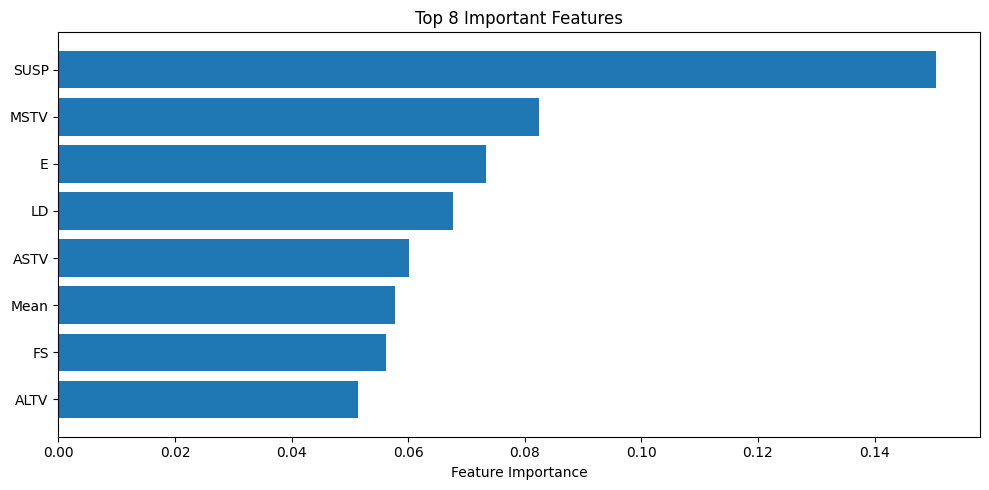

In [27]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assume df is your full DataFrame with features + 'CLASS' and 'NSP' columns

# Drop labels from features
X = df.drop(columns=['CLASS', 'NSP'])
y = df['NSP']  # or use 'CLASS' for 10-class problem

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features (like in your model)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# Train random forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_scaled, y_train)

# Feature importance
importances = rf.feature_importances_
feature_names = X.columns

# Combine and sort
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display top 8
print("🔝 Top 8 Important Features:")
print(importance_df.head(8))

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.barh(importance_df.head(8)['Feature'], importance_df.head(8)['Importance'])
plt.xlabel("Feature Importance")
plt.title("Top 8 Important Features")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
